### Pipline Creation 

In [1]:
from sklearn.pipeline import Pipeline
from src.components.data_tranformation import DataCleaning, Date_Encoding
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import pickle

In [4]:
data = pd.read_csv('marketing_cleaned.csv')
df = data.copy()

# Define pipeline steps with RobustScaler applied to the whole dataset
pipeline = Pipeline([
    ('date_transformer', Date_Encoding()),  # Convert datetime to numeric
    ('preprocessor', ColumnTransformer([
        ('categorical', OneHotEncoder(), ['Education', 'Marital_Status']),  # One-hot encoding for categorical columns
    ], remainder='passthrough')),  # Remainder='passthrough' preserves the columns not specified in transformers
    ('scaler', RobustScaler()),  # RobustScaler applied to the whole dataset
    ('pca', PCA(n_components=2)),  # PCA with 2 components
    ('kmeans', KMeans(n_clusters=3, random_state=0, init = 'k-means++'))  # KMeans clustering with 3 clusters
])


pipeline.fit_transform(df)

array([[4.77823066, 1.40180224, 6.52867437],
       [2.70304509, 5.45946362, 0.25724949],
       [2.07447778, 1.9494726 , 3.25847883],
       ...,
       [2.09688924, 2.74977029, 2.50255472],
       [1.49590199, 2.26754767, 3.1529624 ],
       [1.68977965, 5.10033824, 1.2106031 ]])

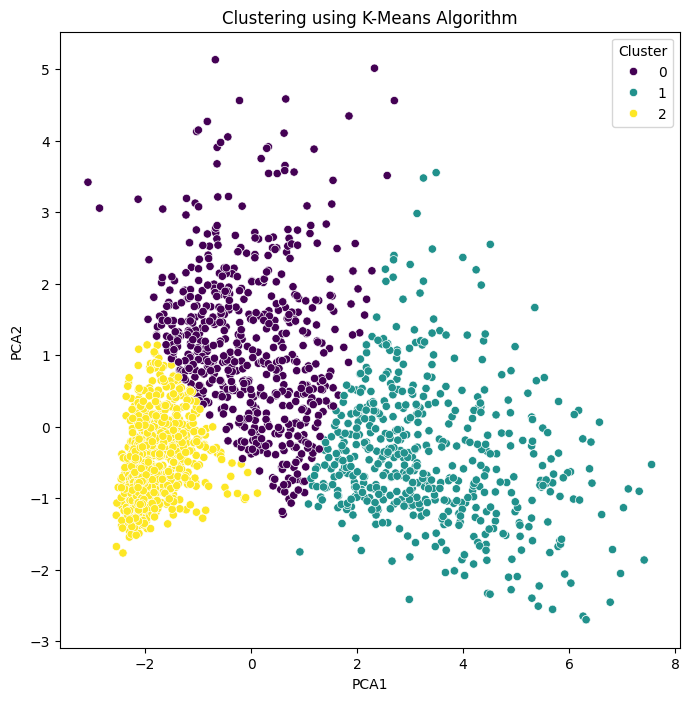

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

kmeans_labels = pipeline.named_steps['kmeans'].labels_

pca_components = pipeline.named_steps['pca'].transform(pipeline.named_steps['scaler'].transform(pipeline.named_steps['preprocessor'].transform(pipeline.named_steps['date_transformer'].transform(df))))

# Create a DataFrame with PCA components
pca_df = pd.DataFrame(data=pca_components, columns=["PCA1", "PCA2"])

# Add cluster labels to the DataFrame
pca_df['Cluster'] = pipeline.named_steps['kmeans'].labels_

# Plot the clusters
plt.figure(figsize=(8, 8))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=pca_df, palette='viridis')
plt.title("Clustering using K-Means Algorithm")
plt.show()

In [7]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

print(silhouette_score(pca_df, kmeans_labels))
print(calinski_harabasz_score(pca_df, kmeans_labels))
print(davies_bouldin_score(pca_df, kmeans_labels))

0.59431254928029
4230.280751578026
0.6729307423849858


In [8]:
with open('kmeans_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

### Prediction

#### 1) singel input (Prediction)

In [9]:
from datetime import datetime
import pandas as pd

# Load the entire pipeline
with open('kmeans_pipeline.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)

# Creating a dictionary with column names and random values
df2 = {
    'Age': [32],
    'Education': ['Graduation'],
    'Marital_Status': ['Partner'],
    'Income': [50000.00],
    'Kidhome' : [2],
    'Teenhome' : [1],
    'Dt_Customer': [datetime(2023, 5, 15)],  # Example date
    'Recency': [25],
    'MntWines': [10],
    'MntFruits': [23],
    'MntMeatProducts': [50],
    'MntFishProducts': [25],
    'MntSweetProducts': [8],
    'MntGoldProds': [5],
    'NumDealsPurchases': [8],
    'NumWebPurchases': [15],
    'NumCatalogPurchases': [16],
    'NumStorePurchases': [23],
    'NumWebVisitsMonth': [8],
    'AcceptedCmp3': [0],
    'AcceptedCmp4': [0],
    'AcceptedCmp5': [0],
    'AcceptedCmp1': [1],
    'AcceptedCmp2': [0],
    'Response': [1]
}

# Create a DataFrame
test = pd.DataFrame(df2)

cluster = loaded_pipeline.predict(test)[0]
cluster


0

#### 2) Multi Input Prediction

In [10]:
import pandas as pd
import pickle

data = pd.read_csv('marketing_cleaned.csv')

with open('kmeans_pipeline.pkl', 'rb') as f:
    pipeline = pickle.load(f)

cluster = pipeline.predict(data)
cluster

array([1, 2, 1, ..., 0, 0, 2])

#### Getting Essential data components for evaluation using pipline

In [11]:
kmeans_labels = pipeline.named_steps['kmeans'].labels_
pca_components = pipeline.named_steps['pca'].transform(pipeline.named_steps['scaler'].transform(pipeline.named_steps['preprocessor'].transform(pipeline.named_steps['date_transformer'].transform(df))))
pca_df = pd.DataFrame(data=pca_components, columns=["PCA1", "PCA2"])
pca_df['Cluster'] = pipeline.named_steps['kmeans'].labels_


from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

print(silhouette_score(pca_df, kmeans_labels))
print(calinski_harabasz_score(pca_df, kmeans_labels))
print(davies_bouldin_score(pca_df, kmeans_labels))

0.59431254928029
4230.280751578026
0.6729307423849858
